In [1]:
import lightkurve as lk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

In [3]:
toi = tois[tois["TOI"] == 144.01].iloc[0]
period = toi["Period (days)"]
epoch = toi["Epoch (BJD)"]
depth = toi["Depth (ppm)"]

# Stellar properties
tic = toi['TIC ID']
temp_eff = toi['Stellar Eff Temp (K)']
temp_eff_err = toi['Stellar Eff Temp (K) err']
log_g = toi['Stellar log(g) (cm/s^2)']
log_g_err = toi['Stellar log(g) (cm/s^2) err']
r_star = toi['Stellar Radius (R_Sun)']
r_star_err = toi['Stellar Radius (R_Sun) err']

In [4]:
# Download fits files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()

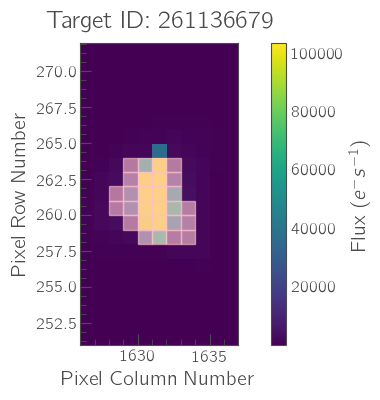

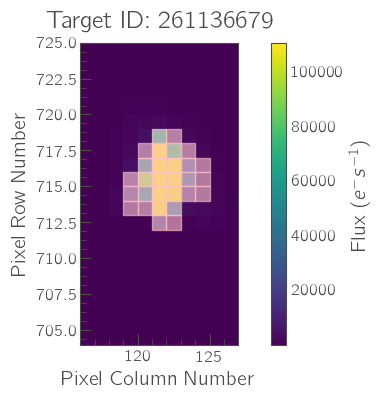

In [5]:
for tpf in tpf_collection:
    tpf.plot(aperture_mask='pipeline')

In [6]:
def get_transit_mask(t, transit_time, period, duration=0.2):
    
    hp = 0.5*period
    return np.abs((t-transit_time+hp) % period - hp) < 0.5*duration

In [11]:
lc_collection = []

for tpf in tpf_collection:

    mask = get_transit_mask(tpf.time, epoch, period)
    
    pld = tpf.to_corrector('pld')
    lc = pld.correct(cadence_mask=~mask, use_gp=True)
    
    lc_collection.append(lc)

In [12]:
lc = lc_collection[0].normalize()
if len(lc_collection) > 1:
    lc = lc.append([next_lc.normalize() for next_lc in lc_collection[1:]])

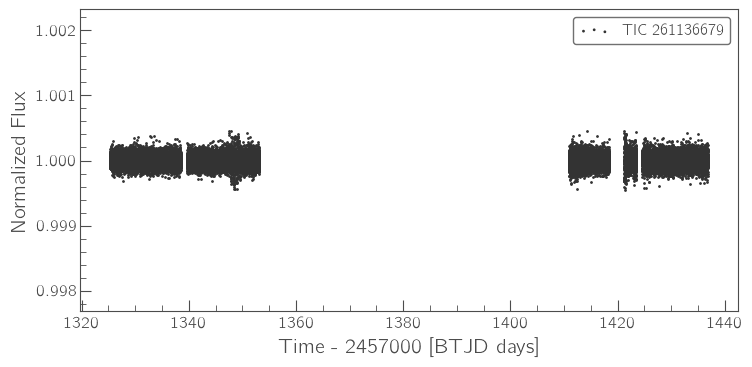

In [14]:
lc.flatten().remove_outliers().scatter()

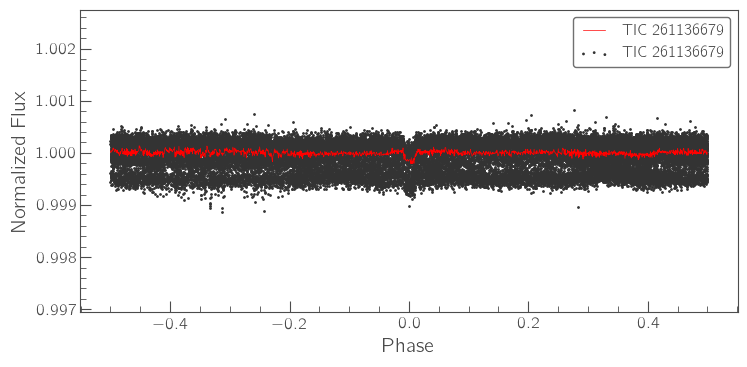

In [15]:
lc = lc.remove_outliers()
ax = lc.fold(period, t0=epoch-2457000).scatter()
lc.fold(period, t0=epoch-2457000).bin(binsize=20).plot(ax=ax, c='r')